To follow along you will need to download the dataset, or at least the positive images and anotations

Resources:   
* https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoEvalDemo.ipynb
* https://www.jeremyjordan.me/evaluating-image-segmentation-models/
* https://www.programcreek.com/python/example/120725/pycocotools.mask.encode
* https://pytorch.org/docs/stable/notes/amp_examples.html#amp-examples

   
I have also taken a few ML courses already and I want to give special thanks to my 6156 ML professor, Dr. Hongfei Xue, for piquing my interest to computer vision and to my Applied Computer Vison professor, Rick Chakra, as the way he taught really solidified my interest in computer vision.

# FLC Notebook Benchmarking Replication

Paper can be found here: [https://www.gperezs.com/papers/bppa.pdf](https://www.gperezs.com/papers/bppa.pdf) and their CVPR 2019 workshop publication can be found here [https://biomedicalcomputervision.uniandes.edu.co/publications/finding-four-leaf-clovers-a-benchmark-for-fine-grained-object-localization/](https://biomedicalcomputervision.uniandes.edu.co/publications/finding-four-leaf-clovers-a-benchmark-for-fine-grained-object-localization/)

Given over 100,000 images and many types of annotations, instane, semantic etc... how do we get this ready for use?   
Here is a file tree of the [FLC data](https://drive.google.com/file/d/1fq6ZeVg2-CjRtKgcBcnKy9jLfUIabfe8/view?usp=sharing)   
```
FLC2019 % tree -C -r -I '*.jpg|*.png|*.mat'   
.
├── trainval
│   ├── coco_annotations
│   │   ├── leaves_trainval_pos.json
│   │   ├── leaves_trainval_negs.json
│   │   ├── instances_trainval_pos.json
│   │   ├── instances_trainval_negs.json
│   │   └── instances_trainval_hard_pos.json
│   ├── SegmentationClass
│   ├── JPEGImages_pos
│   ├── JPEGImages
│   └── BorderClass
├── test
│   ├── gt_mats_pos
│   ├── gt_mats
│   │   └── gt_mats_pos
│   ├── coco_annotations
│   │   ├── leaves_test_pos.json
│   │   ├── leaves_test_negs.json
│   │   ├── instances_test_pos.json
│   │   ├── instances_test_negs.json
│   │   ├── instances_test_hard_pos.json
│   │   └── instances_test_all.json
│   ├── SegmentationClass
│   ├── JPEGImages_pos
│   ├── JPEGImages_neg
│   ├── JPEGImages
│   ├── BorderClass_pos
│   ├── BorderClass_alejo
│   └── BorderClass
│       └── BorderClass_pos
└── create_contours.py

```   

As far as data we will be using, we will not be using the .mat files or the BorderClass files.   
Here is some more information:   
* In the **trainval**/JPEGImages_pos dir, we have 1000 jpg files totalling 1.63GB. These are images *with* four-leaf clovers   
* In the **trainval**/JPEGImages dir, we have 52,638 jpg files totalling 23.8GB. These are images *without* four-leaf clovers as well as the same 1000 images *with* four-leaf clovers   
  
-----

*   In the **test**/JPEGImages_pos dir, we have 500 jpg files totalling 888.8MB. These are images *with* four-leaf clovers  
*   In the **test**/JPEGImages_neg dir, we have 51,671 jpg files totalling 22.2GB. These are images *without* four-leaf clovers  
*   Additionally, we have the  **test**/JPEGImages dir which combines both the pos and neg images into a single dir   
  
-----   
   
According to their paper:

| General statistics         | Trainval set | Test set |
|----------------------------|--------------|----------|
| Total positive images      | 1,000        | 500      |
| Total negative images      | 51,637       | 51,670   |
| Total images               | 52,637       | 52,170   |
| 4-leaf clover instances    | 1,412        | 739      |
| 4-leaf clover leaves       | 5,858        | 3,094    |
| 4-leaf clover pixels       | 0.0445%      | 0.0588%  |
| 4-leaf clover boundary pxls| 0.0026%      | 0.0030%  |

Both the trainval and test dirs include a coco_annotations dir, I will be using the *instances_trainval_hard_pos.json* and *instances_test_hard_pos.json* - This is for the sake of my limitation of training time and compute resources. These are standard coco bbox and segmentation annotations for the pos images. They include both three-leaf clovers and four-leaf clovers annotated in all 1500 trainval/test images.

## What results are we trying to replicate?

### Object Detection:   

| Dataset         | Method                | mAP@.5(%) | mAP@[.5, .95] (%) all | mAP@[.5, .95] (%) small | mAP@[.5, .95] (%) medium | mAP@[.5, .95] (%) large |
|-----------------|-----------------------|-----------|-----------------------|-------------------------|--------------------------|-------------------------|
| FLC test (Pos. only) | Mask R-CNN ResNet50+FPN | 44.9      | 36.4                  | 0.0                     | 24.5                     | 36.7                    |
| FLC test        | Mask R-CNN ResNet50+FPN | 9.50      | 7.90                  | 0.0                     | 0.10                     | 10.7                    |

### Instance Segmentation:   

| Dataset  | Method       | mAP@[.5,.95](%) |
|----------|--------------|-----------------|
| FLC(Pos.)| MaskR-CNN R50| 35.0            |
| FLC      | MaskR-CNN R50| 8.0             |   



### Semantic Segmentation:     

| Dataset | Method | mIoU (%) |
|---------|--------|----------|
| FLC (Positives) | MaskR-CNN R50 | 32.71|
| FLC | MaskR-CNN R50 | 7.71 |

Requires:   
torch   
pycocotools   for coco annotations
cv2 for loading images   
numpy

## Installing dependencies

In [1]:
# a useful tool for dealing with coco format annotations
!pip install pycocotools torchinfo torchmetrics

In [2]:
# in case I decide on augmentation
!pip install kornia

## Imports

In [3]:
# our custom dataset class in a separate .py file for multiple dataloader workers
from flc_dataset import FLCDataset

# glob and os for file management
import glob
import os

# ordereddict > standard dict
from collections import OrderedDict

# pycocotools for their great coco utils
from pycocotools import mask as mask_util
from pycocotools.cocoeval import COCOeval
from pycocotools.coco import COCO

# I love tqdm for progress bars
from tqdm import tqdm

# for viewing model information
from torchinfo import summary

import matplotlib.pyplot as plt
import numpy as np

# for easily reading json file results
import json

# torch and torchvision for our device selection, models, ops, transforms, and utils
import torch
from torch.utils.data import DataLoader

import torchvision
# transform
from torchvision.transforms import v2
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


## Gathering our data

In [4]:
# if pos_flc dir doesn't already exist (these are ONLY the positive images)

if not os.path.exists('pos_flc'):
    !unzip /content/drive/MyDrive/clovers/maskrcnncustom/pos_flc.zip

## Datasets and Dataloaders

Some basic variables

In [5]:
# are we running locally or on colab?
is_colab = True

# where we will save our checkpoints
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# and what device?
device = torch.device('cuda') if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else torch.device('cpu')
print(f'{device = }\n')

# image dirs
trainval_pos_img_dir = 'pos_flc/trainval/JPEGImages_pos' if is_colab else '/Users/mattsloan/Downloads/FLC2019/trainval/JPEGImages_pos'
test_pos_img_dir = 'pos_flc/test/JPEGImages_pos' if is_colab else '/Users/mattsloan/Downloads/FLC2019/test/JPEGImages_pos'

# coco annotation files
trainval_pos_ann = 'pos_flc/trainval/coco_annotations/instances_trainval_pos.json' if is_colab else '/Users/mattsloan/Downloads/FLC2019/trainval/coco_annotations/instances_trainval_pos.json'
test_pos_ann = 'pos_flc/test/coco_annotations/instances_test_pos.json' if is_colab else '/Users/mattsloan/Downloads/FLC2019/test/coco_annotations/instances_test_pos.json'

device = device(type='cuda')



our datasets

In [6]:
# load the datasets - pass the image dir and annotation file


# training dataset
train_dataset = FLCDataset(root_dir=trainval_pos_img_dir, annotation_file=trainval_pos_ann, is_training=True)

# testing dataset
test_dataset = FLCDataset(root_dir=test_pos_img_dir, annotation_file=test_pos_ann)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


our dataloaders

In [7]:
# dataloaders

# when using a batch size > 1 we need to pass the data 'kindly'
def collate_fn(batch):
    return tuple(zip(*batch))

# I used these for debugging and testing optimizers and configd
# train_dataset = torch.utils.data.Subset(train_dataset, list(range(len(train_dataset)//4)))
# test_dataset = torch.utils.data.Subset(test_dataset, list(range(len(test_dataset)//4)))
train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True, num_workers=3, collate_fn=collate_fn, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=1, collate_fn=collate_fn)

## Our reusable functions

Checkpoint loading in case we need to pause and come back later

In [8]:
def load_checkpoint(checkpoint_path, model, optimizer, scheduler):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    return start_epoch, model, optimizer, scheduler

Since we end up piecing together the semantic segmentation model we need to manually define the loss function. The object detectoin and instance segmentation models return a loss dict when in training mode and the actual outputs in eval mode.

In [9]:
def compute_semantic_loss(outputs, segmentation_masks):
    # regular cross entropy loss since each pixel is a classification between background and FLC
    ce_loss = torch.nn.CrossEntropyLoss()
    loss = ce_loss(outputs, segmentation_masks)
    return loss

Everything that goes into training a single epoch

In [10]:
# attempting mixed precision
# https://pytorch.org/docs/stable/notes/amp_examples.html#typical-mixed-precision-training
        #######TEST
# use_kornia = False
# import kornia.augmentation as K
# gpu_jitter = K.ColorJitter(
#     brightness=0.2,
#     contrast=0.2,
#     saturation=0.2,
#     hue=0.1,
#     p=2/3  #
# ).cuda()
scaler = torch.amp.grad_scaler.GradScaler()
def train_one_epoch(model, optimizer, train_loader, device, epoch):
  # Initialize dictionary to store cumulative losses
   cumulative_losses = {}
   loss_count = 0
   model.train()
   running_loss = 0.0
   num_mini_batches = len(train_loader)

   progress_bar = tqdm(train_loader, desc=f'Epoch {epoch}')

   for i, (images, targets) in enumerate(progress_bar):
       optimizer.zero_grad()
       with torch.autocast(device_type='cuda'):
          # so the semantic model does not take this format, so we need to differentiate
          # this is for object detection and instance segmentation
          if isinstance(targets, dict) or (isinstance(targets, list) and isinstance(targets[0], dict)):

              images = [image.to(device) for image in images]
              # targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
              to_keep = ['boxes', 'labels', 'masks']
              targets = [{k: v.to(device) for k, v in t.items() if k in to_keep} for t in targets]



              loss_dict = model(images, targets)
              losses = sum(loss for loss in loss_dict.values())

            # for semantic we'll do them a little differently
          else:
              # instead of a list we'll stack tensors
              images = torch.stack([image.to(device) for image in images])
              segmentation_masks = torch.stack([mask.to(device) for mask in targets])
              outputs = model(images)
              loss = compute_semantic_loss(outputs, segmentation_masks)

              losses = loss

          if not torch.isfinite(losses):
              print(f'Loss is {losses}, skipping batch')
              print(f'Loss dict: {loss_dict}')
              continue

          # losses.backward()
          scaler.scale(losses).backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
          scaler.step(optimizer)
          scaler.update()
          # optimizer.step()

       running_loss += losses.item()
       current_loss = running_loss / (i + 1)

       # Update progress bar description with current loss
       progress_bar.set_description(
           f'Epoch {epoch} - Loss: {current_loss:.4f} - LR: {optimizer.param_groups[0]["lr"]:.6f}'
       )

      #  # how many times do we want to show the loss components?
      #  show_loss_components = 3 # show loss components 2 times per epoch

      #  if i % (num_mini_batches//show_loss_components) == 0 and i > 1:# and isinstance(targets, dict):
      #      print(f'\nBatch {i} Loss Components:')
      #      for k, v in loss_dict.items():
      #          print(f'{k}: {v.item():.4f}')
      #      print()



      # how many times do we want to show the loss components?
       show_loss_components = 3  # show loss components 3 times per epoch

       if i % (num_mini_batches//show_loss_components) == 0 and i > 1:
          print(f'\nBatch {i} Average Loss Components:')

          if loss_count > 0:
            # print means
            # also the mean sum
            loss_sum = 0
            for k in cumulative_losses:
                mean_loss = cumulative_losses[k] / loss_count
                loss_sum += mean_loss
                print(f'{k}: {mean_loss:.4f}')
            print(f'Sum: {loss_sum:.4f}')
            print()
          # reset
          cumulative_losses = {}
          loss_count = 0
       else:
          # sum them
          loss_count += 1
          for k, v in loss_dict.items():
              if k not in cumulative_losses:
                  cumulative_losses[k] = 0
              cumulative_losses[k] += v.item()


   return running_loss / len(train_loader)

In [11]:
# pick a random number between 0 and len(test_dataset)
def random_test_image(test_dataset=test_dataset):
  rand_idx = np.random.randint(0, len(test_dataset))
  print(rand_idx)

  # get outputs
  model.eval()
  outputs = model([test_dataset[rand_idx][0].to(device)])

  # visualize bbox's and seg using matplotlib.plt
  bboxes = outputs[0]['boxes'].cpu().detach().numpy()
  labels = outputs[0]['labels'].cpu().detach().numpy()
  scores = outputs[0]['scores'].cpu().detach().numpy()
  print(scores[:15])

  plt.imshow(test_dataset[rand_idx][0].permute(1, 2, 0))
  plt.axis('off')
  # show bboxes

  # filter out all but top 5
  bboxes = bboxes[:5]
  labels = labels[:5]
  scores = scores[:5]

  for box, label, score in zip(bboxes, labels, scores):
      if score > 0.5:
          x1, y1, x2, y2 = box
          plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=2))
          plt.text(x1, y1, f'{label}: {score:.2f}', color='red', fontsize=12)
  plt.show()

Everything that goes into the training loops:   
* train one epoch    
* track losses
* save checkpoint

In [12]:
def train_fn(model, optimizer, train_loader, device, epochs, checkpoint_fname = 'checkpoint_epoch', start_epoch=0):

  losses = []

  for epoch in range(start_epoch, epochs):
    train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch)
    losses.append(train_loss)
    # step the plateau scheduler with the training loss
    scheduler.step(train_loss)
    # scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch: {epoch}, Training Loss: {train_loss:.4f}, LR {current_lr} \n')
    print(f'-'*30)

    if (epoch + 1) % 3 == 0 or epoch+1 == epochs:
      #  https://pytorch.org/tutorials/beginner/saving_loading_models.html
      checkpoint_path = os.path.join(checkpoint_dir, f"{checkpoint_fname}_optim_{str(type(optimizer)).split('.')[-1][:-2]}_loss_{train_loss:.4f}_epoch_{epoch+1}.pth")
      torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'scheduler_state_dict': scheduler.state_dict(),
          'loss': train_loss,
      }, checkpoint_path)
      print(f'Saved checkpoint at epoch {epoch+1} to {checkpoint_path}')



      # only the newest checkpoint
      !cp "{checkpoint_path}" /content/drive/MyDrive/clovers/maskrcnncustom/checkpoints/

    random_test_image()

  return model, losses

These are our mAP evaluation functions that heavily rely on pycocotools.    
I'm so glad for https://github.com/cocodataset/cocoapi - specifically https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoEvalDemo.ipynb for the eval examples

In [13]:
def evaluate_model(model, test_loader, gt_path, seg_or_bbox='bbox', device='cuda'):
    model = model.to(device)
    model.eval()
    detections = []

    # let's get some preds
    with torch.no_grad(), torch.autocast(device_type='cuda'):
        for batch_imgs, batch_targets in tqdm(test_loader):
            batch_imgs = [img.to(device) for img in batch_imgs]
            outputs = model(batch_imgs)

            # extract and store info
            for preds, target in zip(outputs, batch_targets):
                img_id = target['image_id'].item()
                orig_height, orig_width = target['original_size']
                C, new_height, new_width = batch_imgs[0].shape

                # our scaling (since the model resizes)
                scale_w = orig_width / new_width
                scale_h = orig_height / new_height

                # calculate new outputs
                # move to cpu but keep as tensor
                boxes = preds['boxes'].cpu()#.numpy()
                # filter valid bbox coords on gpu (or whatever device)
                # also learned we can't use 'and' we must use & in pytorch
                valid_preds = ((boxes[:, 2] - boxes[:, 0] > 0) & (boxes[:, 3] - boxes[:, 1] > 0))
                boxes = boxes[valid_preds]

                # same for if box preds are invalid so are the scores
                scores = preds['scores'][valid_preds]
                labels = preds['labels'][valid_preds]

                # handle masks if it's for instance segmentatoin
                if seg_or_bbox == 'segm' and 'masks' in preds:
                    masks = (preds['masks'][valid_preds] > 0.5)

                    # now move to cpu

                    boxes = boxes.cpu().numpy()
                    scores = scores.cpu().numpy()
                    labels = labels.cpu().numpy()
                    # masks are binary ints
                    masks = masks.cpu().numpy().astype(np.uint8)

                    # and now scale them
                    boxes[:, [0, 2]] *= scale_w
                    boxes[:, [1, 3]] *= scale_h

                    # create preds for valid detections
                    for idx in range(len(boxes)):
                        # boxes -> box -> x1, y1, x2, y2
                        x1, y1, x2, y2 = boxes[idx]
                        # encode and decode
                        rle = mask_util.encode(np.asfortranarray(masks[idx][0]))
                        rle['counts'] = rle['counts'].decode('utf-8')
                        pred_dict = {
                            'image_id': int(img_id),
                            'category_id': int(labels[idx]),
                            'bbox': [float(x1), float(y1), float(x2 - x1), float(y2 - y1)],
                            'score': float(scores[idx]),
                            # i'm so glad that pycocotools has an RLE util for masks... because it's confusing
                            # credit to https://www.programcreek.com/python/example/120725/pycocotools.mask.encode
                            'segmentation': rle#mask_util.encode(np.asfortranarray(masks[idx][0]))
                        }
                        detections.append(pred_dict)



                # if not segmentation then it's for bbox
                else:

                  boxes = boxes.cpu().numpy()
                  scores = scores.cpu().numpy()
                  labels = labels.cpu().numpy()

                  # and now scale them
                  boxes[:, [0, 2]] *= scale_w
                  boxes[:, [1, 3]] *= scale_h

                  # boxes -> box -> x1, y1, x2, y2
                  for idx in range(len(boxes)):
                      x1, y1, x2, y2 = boxes[idx]

                      # add our info to a dict for json
                      pred_dict = {
                          'image_id': int(img_id),
                          'category_id': int(labels[idx]),
                          'bbox': [float(x1), float(y1), float(x2-x1), float(y2-y1)],
                          'score': float(scores[idx])
                      }

                      detections.append(pred_dict)

    det_path = 'detections.json'
    with open(det_path, 'w') as f:
        json.dump(detections, f)

    # coco eval... straight from the pycocotools eval notebook
    gt = COCO(gt_path)
    dt = gt.loadRes(det_path)

    # ok let's check for missing stuff from the gt's and remove if any
    gt_image_ids = set([img['id'] for img in gt.imgs.values()])
    pred_image_ids = set([pred['image_id'] for pred in detections])

    # any miissing? let's find them
    gt_missing_in_preds = gt_image_ids - pred_image_ids
    print(f"Image IDs in ground truth not in predictions: {gt_missing_in_preds}")

    # and remove them
    # images first
    gt.dataset['images'] = [img for img in dt.dataset['images'] if img['id'] in pred_image_ids]
    # now id's
    valid_image_ids = pred_image_ids
    # and annotations
    valid_anotation_ids = [ann['id'] for ann in gt.dataset['annotations'] if ann['image_id'] in valid_image_ids]

    gt.dataset['annotations'] = [ann for ann in gt.dataset['annotations'] if ann['id'] in valid_anotation_ids]

    gt.createIndex()

    evaluator = COCOeval(gt, dt, seg_or_bbox)
    evaluator.evaluate()
    evaluator.accumulate()
    evaluator.summarize()

    """
    # just making them look better
    # instance seg
    # We only care about map 0.5- 0.95 all

    # obj det
    # We only care about map 0.5,
                             0.5-0.95 all,
                             0.5-0.95 small,
                             0.5-0.95 medium,
                             0.5-0.95 large,

      this is what the output would look like but what we return we should cherry pick

      Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.505 [0]
      Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.697 [1]
      Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.573
      Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.586 [3]
      Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.519 [4]
      Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.501 [5]
      Average Recall     (AR) @[ IoU=0.50:0.95 etc
    """
    results = {
        'mAP@.5(%)': evaluator.stats[1] * 100,
        'mAP@[.5,.95](%) all': evaluator.stats[0] * 100,
        'mAP@[.5,.95](%) small': evaluator.stats[3] * 100,
        'mAP@[.5,.95](%) medium': evaluator.stats[4] * 100,
        'mAP@[.5,.95](%) large': evaluator.stats[5] * 100
    }

    print(f"\n{seg_or_bbox.capitalize()} Results:")
    print("-" * 40)
    for name, value in results.items():
        print(f"{name:<25} {value:>8.2f}")

    return results

## Let's put together our first models!

### Object Detection   
The paper uses Mask R-CNN ResNet50+FPN - I believe there is a pre-trained pytorch model we can begin using

In [14]:
# model creation
model = maskrcnn_resnet50_fpn_v2(
    weights=MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT
)

#  Background + four-leaf clover
num_classes = 2
# adjust the box predictor for our number of classes
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
# set to kaiming weights
# torch.nn.init.kaiming_normal_(model.roi_heads.box_predictor.cls_score.weight, mode='fan_out', nonlinearity='relu')
# adjust the mask predictor for our number of classes
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 256, num_classes)
# torch.nn.init.kaiming_normal_(model.roi_heads.mask_predictor.conv5_mask.weight, mode='fan_out', nonlinearity='relu')



learning_rate = 0.01
momentum = 0.9
weight_decay = 1e-4


# optimizer = torch.optim.SGD(model.parameters(),
#                             lr=learning_rate,
#                             momentum=momentum,
#                             weight_decay=weight_decay)


# learning_rate = 0.01
# momentum = 0.9
# weight_decay = 1e-4
other_lr = 0.03
optimizer = torch.optim.SGD([{"params": model.backbone.parameters(), 'lr': 0.05},
                             {"params": model.rpn.parameters(), 'lr': other_lr},
                             {"params": model.roi_heads.parameters()}],
                             lr=learning_rate,
                             weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
   optimizer,
   mode='min',
   factor=.1,
   patience=2
)
# steplr
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=1/3)

epochs = 10
model = model.to(device)

I only found this because when I was running my eval, my annotations were nott the same size as my outputs... had to resize them to compare.

In [15]:
print('original sizing')
print(model.transform)
# standard resize is Resize(min_size=(800,), max_size=1333, mode='bilinear')
# do we get better results with higher res?

# I believe all resolutions range from 1836 to 4160


# can try these too
# obj_det_model.transform.min_size=(800,)
# obj_det_model.transform.max_size=1667

# let's incrase the min to the smallest size image
# model.transform.min_size=(1836,)
# and the max size to double
# model.transform.max_size=1333*2 # 2666
# model.transform.min_size=(1200,)
# # model.transform.max_size=2774
# model.transform.max_size=3328
print('new resizing')
print(model.transform)

original sizing
GeneralizedRCNNTransform(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    Resize(min_size=(800,), max_size=1333, mode='bilinear')
)
new resizing
GeneralizedRCNNTransform(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    Resize(min_size=(800,), max_size=1333, mode='bilinear')
)


In [16]:
# make sure they're all trainable
for param in model.parameters():
    param.requires_grad = True

In [17]:
model

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [18]:
summary(model)

Layer (type:depth-idx)                             Param #
MaskRCNN                                           --
├─GeneralizedRCNNTransform: 1-1                    --
├─BackboneWithFPN: 1-2                             --
│    └─IntermediateLayerGetter: 2-1                --
│    │    └─Conv2d: 3-1                            9,408
│    │    └─BatchNorm2d: 3-2                       128
│    │    └─ReLU: 3-3                              --
│    │    └─MaxPool2d: 3-4                         --
│    │    └─Sequential: 3-5                        215,808
│    │    └─Sequential: 3-6                        1,219,584
│    │    └─Sequential: 3-7                        7,098,368
│    │    └─Sequential: 3-8                        14,964,736
│    └─FeaturePyramidNetwork: 2-2                  --
│    │    └─ModuleList: 3-9                        985,088
│    │    └─ModuleList: 3-10                       2,361,344
│    │    └─LastLevelMaxPool: 3-11                 --
├─RegionProposalNetwork: 1-3      

Epoch 0 - Loss: 2.2462 - LR: 0.050000:  34%|███▍      | 113/333 [00:38<01:02,  3.53it/s]


Batch 111 Average Loss Components:
loss_classifier: 0.4511
loss_box_reg: 0.0161
loss_mask: 1.6065
loss_objectness: 0.1630
loss_rpn_box_reg: 0.0075
Sum: 2.2442



Epoch 0 - Loss: 2.2428 - LR: 0.050000:  67%|██████▋   | 224/333 [01:10<00:33,  3.27it/s]


Batch 222 Average Loss Components:
loss_classifier: 0.4507
loss_box_reg: 0.0139
loss_mask: 1.6062
loss_objectness: 0.1623
loss_rpn_box_reg: 0.0080
Sum: 2.2411



Epoch 0 - Loss: 2.2350 - LR: 0.050000: 100%|██████████| 333/333 [01:41<00:00,  3.27it/s]


Epoch: 0, Training Loss: 2.2350, LR 0.05 

------------------------------
207
[0.56142235 0.55745393 0.54756635 0.5379866  0.52584255 0.52322173
 0.5213927  0.51438636 0.51138526 0.5067921  0.49498966 0.494711
 0.49163824 0.48772192 0.4864437 ]


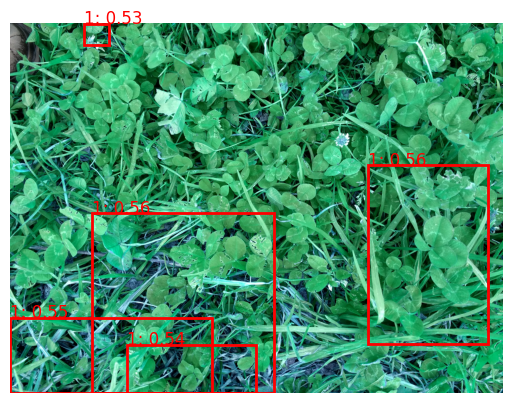

Epoch 1 - Loss: 2.2310 - LR: 0.050000:  34%|███▎      | 112/333 [00:31<00:55,  3.96it/s]


Batch 111 Average Loss Components:
loss_classifier: 0.4513
loss_box_reg: 0.0178
loss_mask: 1.5892
loss_objectness: 0.1629
loss_rpn_box_reg: 0.0076
Sum: 2.2288



Epoch 1 - Loss: 2.2341 - LR: 0.050000:  67%|██████▋   | 224/333 [01:02<00:33,  3.26it/s]


Batch 222 Average Loss Components:
loss_classifier: 0.4516
loss_box_reg: 0.0162
loss_mask: 1.6209
loss_objectness: 0.1424
loss_rpn_box_reg: 0.0070
Sum: 2.2382



Epoch 1 - Loss: 2.2330 - LR: 0.050000: 100%|██████████| 333/333 [01:33<00:00,  3.58it/s]


Epoch: 1, Training Loss: 2.2330, LR 0.05 

------------------------------
415
[0.59015703 0.56577957 0.5407915  0.5147803  0.5107855  0.5093471
 0.50914156 0.49790514 0.49487612 0.48194548 0.48063177 0.47729957
 0.47683707 0.47498965 0.47463614]


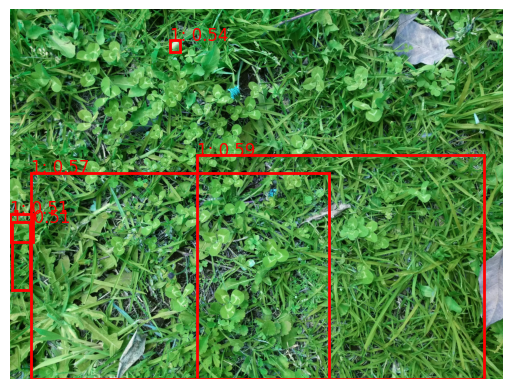

Epoch 2 - Loss: 2.2539 - LR: 0.050000:  34%|███▎      | 112/333 [00:32<00:51,  4.26it/s]


Batch 111 Average Loss Components:
loss_classifier: 0.4510
loss_box_reg: 0.0182
loss_mask: 1.6077
loss_objectness: 0.1700
loss_rpn_box_reg: 0.0077
Sum: 2.2546



Epoch 2 - Loss: 2.2410 - LR: 0.050000:  67%|██████▋   | 223/333 [01:03<00:27,  3.96it/s]


Batch 222 Average Loss Components:
loss_classifier: 0.4510
loss_box_reg: 0.0165
loss_mask: 1.6045
loss_objectness: 0.1487
loss_rpn_box_reg: 0.0072
Sum: 2.2279



Epoch 2 - Loss: 2.2302 - LR: 0.050000: 100%|██████████| 333/333 [01:34<00:00,  3.54it/s]


Epoch: 2, Training Loss: 2.2302, LR 0.05 

------------------------------
Saved checkpoint at epoch 3 to checkpoints/model_lr_0.01_checkpoint_optim_SGD_loss_2.2302_epoch_3.pth
281
[0.62439543 0.6081879  0.5878587  0.57893753 0.5752939  0.5396522
 0.52768254 0.52385604 0.5219884  0.5187603  0.51736087 0.51647246
 0.51399237 0.51189625 0.51161295]


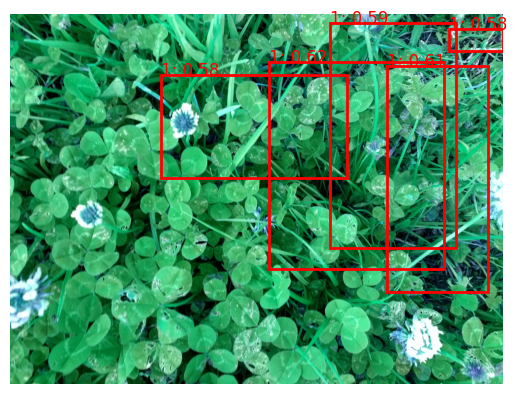

Epoch 3 - Loss: 2.2268 - LR: 0.050000:  34%|███▎      | 112/333 [00:32<00:53,  4.16it/s]


Batch 111 Average Loss Components:
loss_classifier: 0.4515
loss_box_reg: 0.0185
loss_mask: 1.5977
loss_objectness: 0.1522
loss_rpn_box_reg: 0.0073
Sum: 2.2272



Epoch 3 - Loss: 2.2272 - LR: 0.050000:  67%|██████▋   | 223/333 [01:03<00:26,  4.20it/s]


Batch 222 Average Loss Components:
loss_classifier: 0.4499
loss_box_reg: 0.0153
loss_mask: 1.5940
loss_objectness: 0.1611
loss_rpn_box_reg: 0.0072
Sum: 2.2274



Epoch 3 - Loss: 2.2330 - LR: 0.050000: 100%|██████████| 333/333 [01:35<00:00,  3.49it/s]


Epoch: 3, Training Loss: 2.2330, LR 0.05 

------------------------------
297
[0.5528733  0.5388533  0.53528905 0.5339189  0.53338146 0.52181166
 0.5192821  0.5141822  0.5134404  0.50750536 0.5058402  0.50498354
 0.5016592  0.49610606 0.49076936]


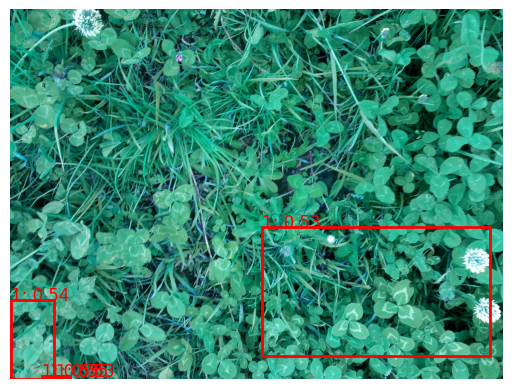

Epoch 4 - Loss: 2.2221 - LR: 0.050000:  34%|███▍      | 113/333 [00:33<00:53,  4.11it/s]


Batch 111 Average Loss Components:
loss_classifier: 0.4510
loss_box_reg: 0.0183
loss_mask: 1.5859
loss_objectness: 0.1591
loss_rpn_box_reg: 0.0075
Sum: 2.2218



Epoch 4 - Loss: 2.2166 - LR: 0.050000:  67%|██████▋   | 224/333 [01:04<00:24,  4.37it/s]


Batch 222 Average Loss Components:
loss_classifier: 0.4508
loss_box_reg: 0.0145
loss_mask: 1.5838
loss_objectness: 0.1522
loss_rpn_box_reg: 0.0081
Sum: 2.2094



Epoch 4 - Loss: 2.2212 - LR: 0.050000: 100%|██████████| 333/333 [01:34<00:00,  3.51it/s]


Epoch: 4, Training Loss: 2.2212, LR 0.05 

------------------------------
79
[0.5389843  0.5339905  0.52705145 0.52464294 0.51420367 0.5100363
 0.5082954  0.50681776 0.5044591  0.4883539  0.48409146 0.47932285
 0.4772972  0.47700056 0.47294337]


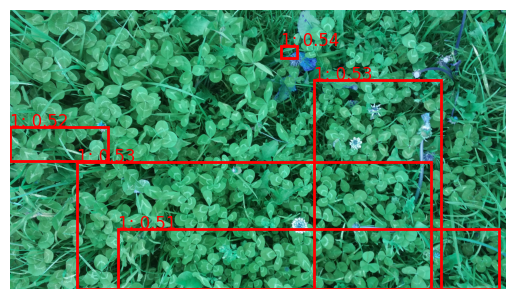

Epoch 5 - Loss: 2.2241 - LR: 0.050000:  34%|███▍      | 113/333 [00:32<00:51,  4.28it/s]


Batch 111 Average Loss Components:
loss_classifier: 0.4507
loss_box_reg: 0.0156
loss_mask: 1.5960
loss_objectness: 0.1566
loss_rpn_box_reg: 0.0073
Sum: 2.2261



Epoch 5 - Loss: 2.2161 - LR: 0.050000:  67%|██████▋   | 223/333 [01:02<00:29,  3.72it/s]


Batch 222 Average Loss Components:
loss_classifier: 0.4500
loss_box_reg: 0.0174
loss_mask: 1.5849
loss_objectness: 0.1486
loss_rpn_box_reg: 0.0072
Sum: 2.2081



Epoch 5 - Loss: 2.2213 - LR: 0.050000: 100%|██████████| 333/333 [01:34<00:00,  3.53it/s]


Epoch: 5, Training Loss: 2.2213, LR 0.05 

------------------------------
Saved checkpoint at epoch 6 to checkpoints/model_lr_0.01_checkpoint_optim_SGD_loss_2.2213_epoch_6.pth
142
[0.6819504  0.6596421  0.65810984 0.64121026 0.6241623  0.61048657
 0.5938871  0.5927009  0.59005135 0.5855252  0.5806607  0.57371736
 0.5681419  0.56649494 0.5662271 ]


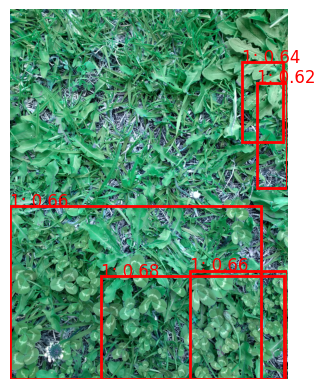

Epoch 6 - Loss: 2.2279 - LR: 0.050000:  34%|███▎      | 112/333 [00:32<00:51,  4.25it/s]


Batch 111 Average Loss Components:
loss_classifier: 0.4500
loss_box_reg: 0.0146
loss_mask: 1.5909
loss_objectness: 0.1641
loss_rpn_box_reg: 0.0078
Sum: 2.2274



Epoch 6 - Loss: 2.2180 - LR: 0.050000:  67%|██████▋   | 224/333 [01:04<00:29,  3.68it/s]


Batch 222 Average Loss Components:
loss_classifier: 0.4496
loss_box_reg: 0.0168
loss_mask: 1.5786
loss_objectness: 0.1560
loss_rpn_box_reg: 0.0074
Sum: 2.2084



Epoch 6 - Loss: 2.2180 - LR: 0.050000: 100%|██████████| 333/333 [01:34<00:00,  3.51it/s]


Epoch: 6, Training Loss: 2.2180, LR 0.05 

------------------------------
21
[0.59488946 0.56686616 0.5592077  0.55786157 0.5524857  0.5506036
 0.5457641  0.5441808  0.5290608  0.5276098  0.5183111  0.51697016
 0.5167337  0.51330644 0.51209044]


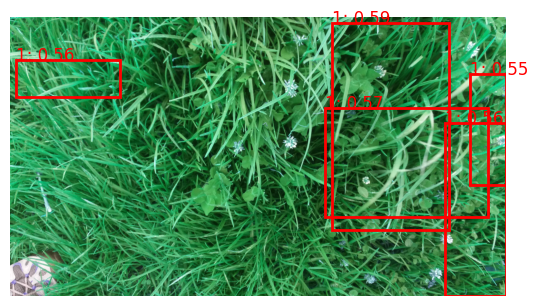

Epoch 7 - Loss: 2.2011 - LR: 0.050000:  34%|███▎      | 112/333 [00:32<01:16,  2.89it/s]


Batch 111 Average Loss Components:
loss_classifier: 0.4492
loss_box_reg: 0.0151
loss_mask: 1.5792
loss_objectness: 0.1486
loss_rpn_box_reg: 0.0073
Sum: 2.1994



Epoch 7 - Loss: 2.2061 - LR: 0.050000:  67%|██████▋   | 223/333 [01:03<00:32,  3.35it/s]


Batch 222 Average Loss Components:
loss_classifier: 0.4498
loss_box_reg: 0.0177
loss_mask: 1.5691
loss_objectness: 0.1660
loss_rpn_box_reg: 0.0080
Sum: 2.2107



Epoch 7 - Loss: 2.2136 - LR: 0.050000: 100%|██████████| 333/333 [01:33<00:00,  3.54it/s]


Epoch: 7, Training Loss: 2.2136, LR 0.05 

------------------------------
401
[0.5282632  0.5090637  0.5050335  0.50426924 0.5014125  0.5008917
 0.49983272 0.49775478 0.48442143 0.47906992 0.47834566 0.47531325
 0.47054073 0.4692642  0.46877563]


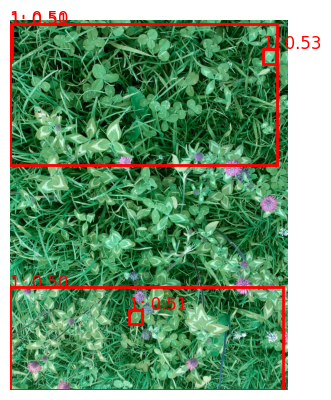

Epoch 8 - Loss: 2.1861 - LR: 0.050000:  34%|███▎      | 112/333 [00:32<00:53,  4.14it/s]


Batch 111 Average Loss Components:
loss_classifier: 0.4494
loss_box_reg: 0.0161
loss_mask: 1.5541
loss_objectness: 0.1575
loss_rpn_box_reg: 0.0076
Sum: 2.1847



Epoch 8 - Loss: 2.1979 - LR: 0.050000:  67%|██████▋   | 223/333 [01:03<00:30,  3.64it/s]


Batch 222 Average Loss Components:
loss_classifier: 0.4504
loss_box_reg: 0.0171
loss_mask: 1.5801
loss_objectness: 0.1542
loss_rpn_box_reg: 0.0074
Sum: 2.2094



Epoch 8 - Loss: 2.2039 - LR: 0.050000: 100%|██████████| 333/333 [01:35<00:00,  3.50it/s]


Epoch: 8, Training Loss: 2.2039, LR 0.05 

------------------------------
Saved checkpoint at epoch 9 to checkpoints/model_lr_0.01_checkpoint_optim_SGD_loss_2.2039_epoch_9.pth
165
[0.6103642  0.57686156 0.5586903  0.54810756 0.54280174 0.52007043
 0.51920724 0.51907897 0.51756704 0.50767016 0.5035789  0.5028156
 0.49789414 0.49551302 0.4925928 ]


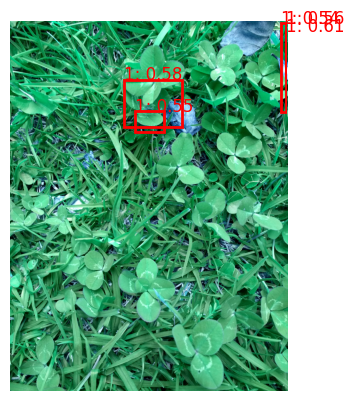

Epoch 9 - Loss: 2.2008 - LR: 0.050000:  34%|███▍      | 113/333 [00:32<01:09,  3.18it/s]


Batch 111 Average Loss Components:
loss_classifier: 0.4481
loss_box_reg: 0.0147
loss_mask: 1.5809
loss_objectness: 0.1487
loss_rpn_box_reg: 0.0069
Sum: 2.1994



Epoch 9 - Loss: 2.2015 - LR: 0.050000:  67%|██████▋   | 224/333 [01:03<00:31,  3.49it/s]


Batch 222 Average Loss Components:
loss_classifier: 0.4500
loss_box_reg: 0.0176
loss_mask: 1.5766
loss_objectness: 0.1545
loss_rpn_box_reg: 0.0076
Sum: 2.2063



Epoch 9 - Loss: 2.2014 - LR: 0.050000: 100%|██████████| 333/333 [01:34<00:00,  3.54it/s]


Epoch: 9, Training Loss: 2.2014, LR 0.05 

------------------------------
Saved checkpoint at epoch 10 to checkpoints/model_lr_0.01_checkpoint_optim_SGD_loss_2.2014_epoch_10.pth
275
[0.63265216 0.6205496  0.61819106 0.5965785  0.5857734  0.5786021
 0.5781868  0.5756732  0.5732271  0.5654045  0.5619096  0.55933034
 0.5578945  0.55529946 0.5535579 ]


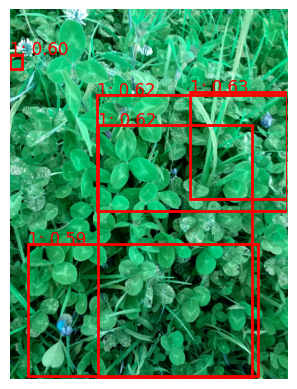

In [19]:
model, losses = train_fn(model, optimizer, train_loader, device, epochs, checkpoint_fname = f'model_lr_{learning_rate}_checkpoint', start_epoch=0)

In [20]:
# 0.01 SGD
# Batch 250 Loss Components:
# loss_classifier: 0.4781
# loss_box_reg: 0.0113
# loss_mask: 0.8719
# loss_objectness: 0.2485
# loss_rpn_box_reg: 0.0148

# Epoch 9 - Loss: 1.4209 - LR: 0.000100: 100%|██████████| 500/500 [02:10<00:00,  3.83it/s]
# Epoch: 9, Training Loss: 1.4209, LR 0.0001

################################################################################
# 0.03 ADAM scheduler 3 factor 0.5
# Epoch 6 - Loss: 0.6421 - LR: 0.007500: 100%|██████████| 500/500 [02:11<00:00,  3.80it/s]

# Batch 498 Average Loss Components:
# loss_classifier: 0.1120
# loss_box_reg: 0.0838
# loss_mask: 0.3845
# loss_objectness: 0.0600
# loss_rpn_box_reg: 0.0084
# Sum: 0.6487

# Epoch: 6, Training Loss: 0.6421, LR 0.0075


# progresss....
# Batch 498 Average Loss Components:
# loss_classifier: 0.0545
# loss_box_reg: 0.0111
# loss_mask: 0.4983
# loss_objectness: 0.1545
# loss_rpn_box_reg: 0.1163
# Sum: 0.8347

# Epoch: 2, Training Loss: 0.8511, LR 0.015
################################################################################

# 0.01 ADAM SCHEDULER 3 FACTOR 0.1

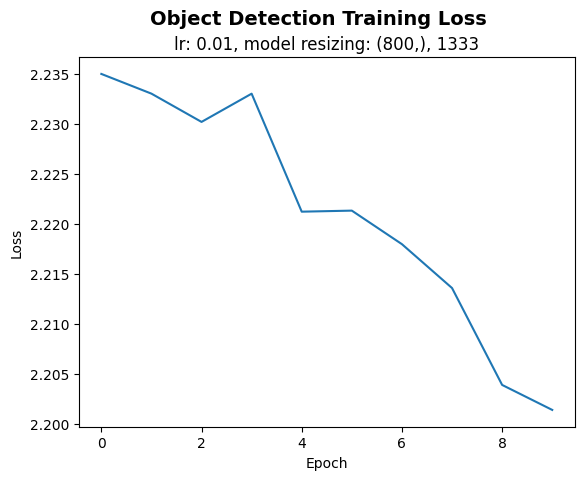

In [21]:
# SGD Epoch: 6, Training Loss: 1.2649, LR 0.01

# plot losses
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.suptitle('Object Detection Training Loss', fontsize=14, fontweight='bold')
plt.title(f'lr: {learning_rate}, model resizing: {model.transform.min_size}, {model.transform.max_size}')
plt.show()

Thank you pycocotools https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoEvalDemo.ipynb

In [22]:
# Evaluate
model.eval()
metrics = evaluate_model(
    model=model,
    test_loader=test_loader,
    gt_path=test_pos_ann,
    device=device,
    seg_or_bbox='bbox'
)

# 4 it/s batch 1

100%|██████████| 499/499 [02:08<00:00,  3.89it/s]


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.38s)
creating index...
index created!
Image IDs in ground truth not in predictions: {301}
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.59s).
Accumulating evaluation results...
DONE (t=0.50s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | ma

Object Detection Baseline

| Dataset         | Method                | mAP@.5(%) | mAP@[.5, .95] (%) all | mAP@[.5, .95] (%) small | mAP@[.5, .95] (%) medium | mAP@[.5, .95] (%) large |
|-----------------|-----------------------|-----------|-----------------------|-------------------------|--------------------------|-------------------------|
| FLC test (Pos. only) | Mask R-CNN ResNet50+FPN | 44.9      | 36.4                  | 0.0                     | 24.5                     | 36.7                    |

Actual

| Dataset         | Method                | mAP@.5(%) | mAP@[.5, .95] (%) all | mAP@[.5, .95] (%) small | mAP@[.5, .95] (%) medium | mAP@[.5, .95] (%) large |
|-----------------|-----------------------|-----------|-----------------------|-------------------------|--------------------------|-------------------------|
| FLC test (Pos. only) | Mask R-CNN ResNet50+FPN | 23.02      | 12.23                  | 0.0                     | 13.62                     | 12.35                    |

### Semantic

In [23]:
# https://lightning.ai/docs/torchmetrics/stable/classification/jaccard_index.html
# we're looking for mIoU, which is the mean across all classes

from torchmetrics import JaccardIndex

iou_metric = JaccardIndex(num_classes=1, average='macro', task='binary').to(device)
model.eval()
for images, targets in tqdm(test_loader):
  with torch.no_grad():
    # gotta make sure we're doing one image at a time
    if len(images) == 1:
      image = images[0].to(device)
      target = targets[0]
      # only care about the mask output
      output = model([image])[0]['masks'].to(device)

      # convert to binary
      preds = (output > 0.5).float().squeeze(1)
      # multiple masks into one
      preds = preds.max(dim=0, keepdim=True)[0]

      gt_masks = target['masks'].to(device).float()
      # multiple masks into one
      gt_masks = (gt_masks.sum(dim=0, keepdim=True) >= 1).float()

      iou_metric.update(preds, gt_masks)


# full score
miou_score = iou_metric.compute()
print()
print(f"semantic Segmentation mIoU: {miou_score.item()}")

100%|██████████| 499/499 [02:09<00:00,  3.85it/s]


semantic Segmentation mIoU: 0.013760962523519993


Semantic Segmentation Baseline

| Dataset  | Method       | mIoU(%) |
|----------|--------------|-----------------|
| FLC(Pos.)| MaskR-CNN R50| 32.71           |


Actual

| Dataset  | Method       | mAP@[.5,.95](%) |
|----------|--------------|-----------------|
| FLC(Pos.)| MaskR-CNN R50| 1.37            |




### Instance Segmentation

In [24]:
# instance segmentation eval is really slow :/
metrics = evaluate_model(
    model=model,
    test_loader=test_loader,
    gt_path=test_pos_ann,
    device=device,
    seg_or_bbox='segm'
)

# 4 it/s batch 1

100%|██████████| 499/499 [24:13<00:00,  2.91s/it]


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=3.17s)
creating index...
index created!
Image IDs in ground truth not in predictions: {301}
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=12.47s).
Accumulating evaluation results...
DONE (t=0.47s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | m

Instance Segmentation Baseline

| Dataset  | Method       | mAP@[.5,.95](%) |
|----------|--------------|-----------------|
| FLC(Pos.)| MaskR-CNN R50| 35.0            |


Actual

| Dataset  | Method       | mAP@[.5,.95](%) |
|----------|--------------|-----------------|
| FLC(Pos.)| MaskR-CNN R50| 0.0            |


